In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sax
import jax.numpy as jnp
from jax import config
config.update("jax_enable_x64", True)
from scipy.signal import StateSpace
from simphony.libraries import ideal
from simphony.utils import dict_to_matrix
from simphony.time_domain.utils import gaussian_pulse
from simphony.time_domain.pole_residue_model import IIRModelBaseband
from simphony.time_domain.utils import pole_residue_to_time_system
from simphony.libraries import siepic
from matplotlib.ticker import FormatStrFormatter


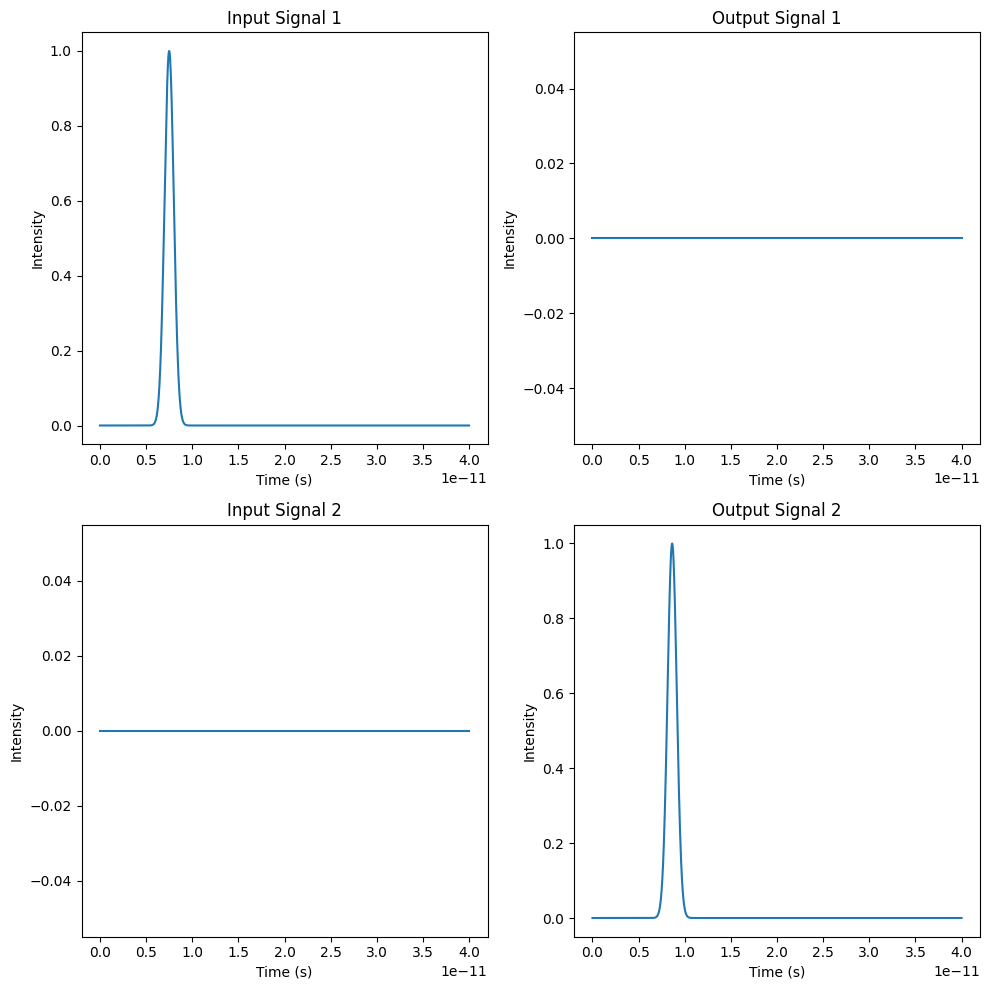

In [7]:
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,o0",   # First input port
        "o1": "coupler,o1",   # Second input port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": ideal.waveguide,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)


N = int(1000)  # Number of time steps
T = 4e-11      # Total time duration (40 ps)
t = jnp.linspace(0, T, N)  # Time array
t0 = T/2 - 5e-12  # Pulse start time
std = 1e-12       # Pulse standard deviation


# Define input signals
impulse_pass = {
    'o0': gaussian_pulse(t, t0 - 0.5 * t0, std),
    'o1': jnp.zeros_like(t)
}


# Convert frequency domain model to a time-domain system
tsys = pole_residue_to_time_system(model)
# Simulate the system's response to the input signals
outputs = tsys.response(impulse_pass)


# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 10))  # 2 rows, 2 columns


# Plot input signals
for i in range(2):
    axs[i, 0].plot(t, jnp.abs(impulse_pass[f'o{i}'])**2)
    axs[i, 0].set_title(f'Input Signal {i+1}')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Intensity')


# Plot output signals
for i in range(2):
    axs[i, 1].plot(t, jnp.abs(outputs[f'o{i}'])**2)
    axs[i, 1].set_title(f'Output Signal {i+1}')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Intensity')


# Adjust layout
plt.tight_layout()
plt.show()


Average delay over the wavelength range: -0.21 ps


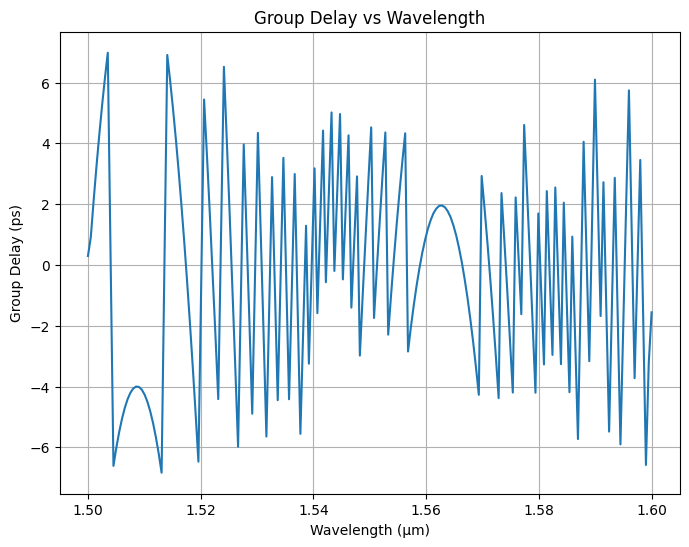

In [9]:
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,o0",   # First input port
        "o1": "coupler,o1",   # Second input port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": ideal.waveguide,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)*1e-6  # Wavelength range (µm)
c = 3e8

s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Waveguide length and loss

# Extract S21 (transmission parameter from port o0 to o1)
s21 = S[:, 1, 0] # S21 as complex values

# Calculate phase of S21
phase = np.unwrap(np.angle(s21))  # Unwrap phase to remove discontinuities

# Calculate frequency (Hz) and angular frequency (rad/s)
frequency = c / (wvl)  # Convert wavelength (µm) to frequency (Hz)
omega = 2 * np.pi * frequency  # Angular frequency (rad/s)

# Calculate group delay
group_delay = -np.gradient(phase, omega)
average_delay = np.mean(group_delay)  # In seconds
average_delay_ps = average_delay * 1e12  # Convert to picoseconds

print(f"Average delay over the wavelength range: {average_delay_ps:.2f} ps")
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(wvl*1e6, group_delay * 1e12)  # Group delay in picoseconds
plt.xlabel("Wavelength (µm)")
plt.ylabel("Group Delay (ps)")
plt.title("Group Delay vs Wavelength")
plt.grid(True)
plt.show()



In [23]:
from numpy.linalg import inv
import scipy.linalg as la
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,o0",   # First input port
        "o1": "coupler,o1",   # Second input port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": ideal.waveguide,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements) # Wavelength range (µm)
c = 3e8

s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Waveguide length and loss

model = IIRModelBaseband(wvl, center_wvl, S, model_order)
sys = model.generate_sys_discrete()

frequencies = 2 * np.pi * c / (wvl)
def discrete_freqresp(A, B, C, D, w_vals, dt):
    I = np.eye(A.shape[0])
    H = np.zeros(len(w_vals), dtype=complex)
    
    for w in w_vals:
        z = np.exp(1j * w * dt)
        
        H[i] = z * np.eye(A.shape[0]) 
         
    return np.array(H)

H = discrete_freqresp(sys.A,sys.B, sys.C,sys.D, frequencies,sys.dt)
w = frequencies
phase = np.angle(H)
# Extract S21 (transmission parameter from port o0 to o1)
dphi_domega = np.gradient(phase, w)  # np.gradient(phase, w) differentiates phase wrt w
group_delay = -dphi_domega
group_delay
plt.figure(figsize=(8, 5))
plt.plot(w, H, label='Group Delay')
specific_freq = 10*1e-6*3.4/3e8
plt.plot(2*np.pi*c/(1.55), 10*1e-6*3.4/3e8, 'ro')
# Set titles and labels
plt.title('Group Delay vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (s)')
plt.grid(True)
plt.legend()


plt.show()


TypeError: only length-1 arrays can be converted to Python scalars

200


In [57]:
10*1e-6*3.4/3e8 - group_delay[100]

np.float64(-7.725369813991366e-17)

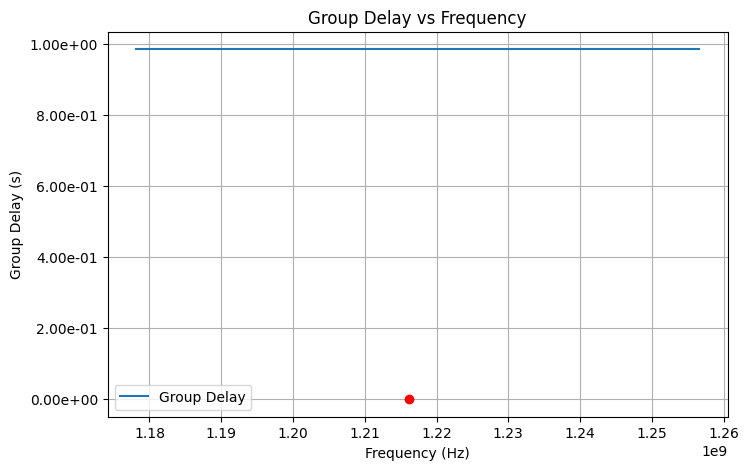

In [6]:
from scipy.signal import ss2tf, bode
from scipy.signal import freqresp
from numpy.linalg import inv
netlist = {
    "instances": {
        "wg": "waveguide",
        "hr": "half_ring",
    },
    "connections": {
        "hr,o2": "wg,o0",
        "hr,o3": "wg,o1",
    },
    "ports": {
        "o0": "hr,o0",
        "o1": "hr,o1",
    }
}

circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "waveguide": ideal.waveguide,
        "half_ring": ideal.coupler,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements) # Wavelength range (µm)
c = 3e8

s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Waveguide length and loss

model = IIRModelBaseband(wvl, center_wvl, S, model_order)
sys = model.generate_sys_discrete()

frequencies = 2 * np.pi * c / wvl
def discrete_freqresp(A, B, C, D, w_vals, dt):
    I = np.eye(A.shape[0])
    H = []
    for w in w_vals:
        z = np.exp(1j * w * dt)
        # Compute (zI - A)^{-1}
        ZinvmA = inv(z*I - A)
        Hw = C @ ZinvmA @ B + D
        H.append(Hw[0,1])  # If single-input, single-output
    return np.array(H)

H = discrete_freqresp(sys.A,sys.B, sys.C,sys.D, frequencies,sys.dt)
w = frequencies
phase = np.angle(H)
# Extract S21 (transmission parameter from port o0 to o1)
dphi_domega = np.gradient(phase, w)  # np.gradient(phase, w) differentiates phase wrt w
group_delay = -dphi_domega
group_delay
plt.figure(figsize=(8, 5))
plt.plot(w, abs(H), label='Group Delay')
plt.plot(2*np.pi*c/(1.55), 10*1e-6*3.4/3e8, 'ro')
# Set titles and labels
plt.title('Group Delay vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (s)')
plt.grid(True)
plt.legend()

# # Option 1: Use scientific notation on the y-axis
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#Option 2 (alternative): Use a specific string format, e.g., 2 decimal places in scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
#plt.ylim([1e-14, 0.25e-12])
plt.show()

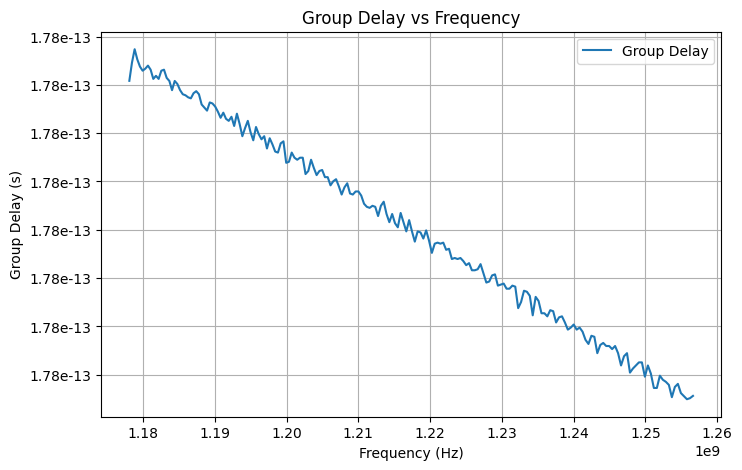

In [33]:
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,port_1",   # First input port
        "o1": "coupler,port_2",
        "o2": "coupler,port_3",
            
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": siepic.y_branch,
    }
)


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements)  # Wavelength range (µm)


# Perform simulation
s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Convert the result to a matrix
model = IIRModelBaseband(wvl, center_wvl, S, model_order)

sys = model.generate_sys_discrete()

frequencies = 2 * np.pi * c / wvl
def discrete_freqresp(A, B, C, D, w_vals, dt):
    I = np.eye(A.shape[0])
    H = []
    for w in w_vals:
        z = np.exp(1j * w * dt)
        # Compute (zI - A)^{-1}
        ZinvmA = inv(z*I - A)
        Hw = C @ ZinvmA @ B + D
        H.append(Hw[0,1])  # If single-input, single-output
    return np.array(H)

H = discrete_freqresp(sys.A,sys.B, sys.C,sys.D, frequencies,sys.dt)
w = frequencies
phase = np.angle(H)
# Extract S21 (transmission parameter from port o0 to o1)
dphi_domega = np.gradient(phase, w)  # np.gradient(phase, w) differentiates phase wrt w
group_delay = -dphi_domega
group_delay
plt.figure(figsize=(8, 5))
plt.plot(w, group_delay, label='Group Delay')

# Set titles and labels
plt.title('Group Delay vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (s)')
plt.grid(True)
plt.legend()
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
plt.show()

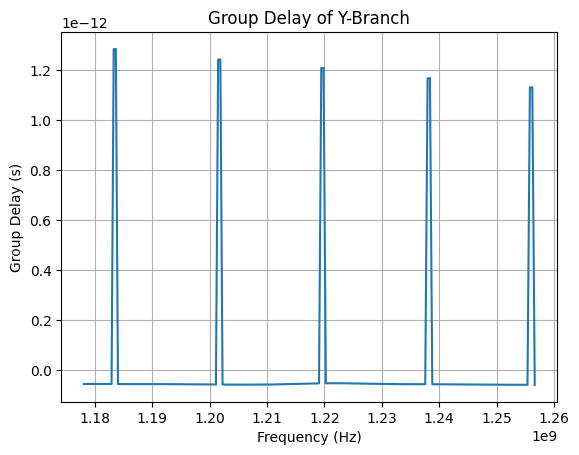

In [50]:
s_matrix = s

s21_phase = np.angle(s_matrix[("o1", "o2")]) # Get phase from S21

# Compute the group delay
dphi = np.gradient(s21_phase, 2*np.pi*frequencies/1e-6)  # Numerical derivative of phase
group_delay = -dphi

# Plot the group delay
plt.plot(frequencies, group_delay)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Group Delay (s)")
plt.title("Group Delay of Y-Branch")
plt.grid()
plt.show()

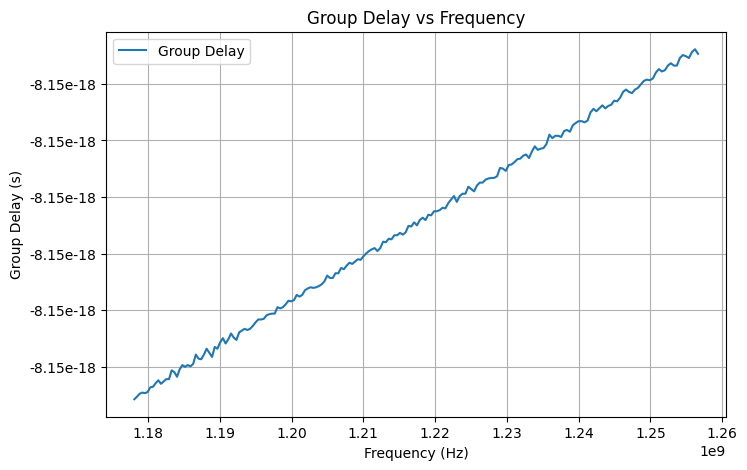

In [ ]:
from scipy.signal import ss2tf, bode
from scipy.signal import freqresp
from numpy.linalg import inv
netlist = {
    "instances": {
        "coupler": "coupler",  # The coupler instance
    },
    "connections": {},  # No internal connections for a single component
    "ports": {
        "o0": "coupler,o0",   # First input port
        "o1": "coupler,o1",   # Second input port
    },

}


circuit, info = sax.circuit(
    netlist=netlist,
    models={
        "coupler": siepic.waveguide,
    }
)
#silicon dioxide for hte cladding and silicone for the inside use the rest to figure it out


num_measurements = 200
model_order = 50
center_wvl = 1.548  # Center wavelength (µm)
wvl = np.linspace(1.5, 1.6, num_measurements) # Wavelength range (µm)
c = 3e8

s = circuit(wl=wvl, wg={"length": 77.0, "loss": 100})
S = np.asarray(dict_to_matrix(s))  # Waveguide length and loss

model = IIRModelBaseband(wvl, center_wvl, S, model_order)
sys = model.generate_sys_discrete()

frequencies = 2 * np.pi * c / (wvl)
def discrete_freqresp(A, B, C, D, w_vals, dt):
    I = np.eye(A.shape[0])
    H = []
    for w in w_vals:
        z = np.exp(1j * w * dt)
        # Compute (zI - A)^{-1}
        ZinvmA = inv(z*I - A)
        Hw = C @ ZinvmA @ B + D
        H.append(Hw[0,1])  # If single-input, single-output
    return np.array(H)

H = discrete_freqresp(sys.A,sys.B, sys.C,sys.D, frequencies,sys.dt)
w = frequencies
phase = np.angle(H)
# Extract S21 (transmission parameter from port o0 to o1)
dphi_domega = np.gradient(phase, w)  # np.gradient(phase, w) differentiates phase wrt w
group_delay = -dphi_domega
group_delay
plt.figure(figsize=(8, 5))
plt.plot(w, group_delay, label='Group Delay')
# Set titles and labels
plt.title('Group Delay vs Frequency')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Group Delay (s)')
plt.grid(True)
plt.legend()

# # Option 1: Use scientific notation on the y-axis
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

#Option 2 (alternative): Use a specific string format, e.g., 2 decimal places in scientific notation
ax = plt.gca()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))

plt.show()
